## ECSE415 Part 2

In [1]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
import cv2
import sklearn
from skimage.feature import hog
from sklearn import svm
from sklearn.model_selection import GridSearchCV

(480, 640, 3)


array([[[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       [[  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0],
        ...,
        [  0,   0,   0],
        [  0,   0,   0],
        [  0,   0,   0]],

       ...,

       [[159, 131,  68],
        [157, 128,  72],
        [155, 125,  75],
        ...,
        [206, 159, 115],
        [210, 163, 119],
        [212, 165, 121]],

       [[160, 132,  69],
        [158, 129,  71],
        [156, 126,  76],
        ...,
        [194, 147, 103],
        [199, 152, 108],
        [202, 155, 111]],

       [[158, 130,  65],
        [156, 127,  69],
        [153, 123,  73],
        ...,
        [184, 137,  93],
        [185, 138,  94],
        [185, 138,  94]]

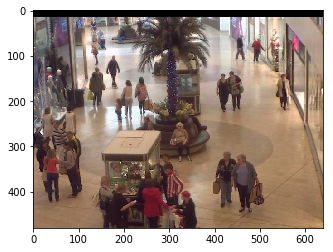

In [26]:
def read_image(number, display=False):
    path = './frames/frames/seq_{}.jpg'.format(str(number).zfill(6))
    img = cv2.imread('./frames/frames/seq_000166.jpg')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if display:
        plt.imshow(img)
        print(img.shape)
    return img
        
read_image(22, display=True)

In [28]:
dataset = np.zeros(shape=(2000,480,640,3))
for i in range(1, 2001):
    dataset[i-1] = read_image(i)

In [29]:
dataset.shape

(2000, 480, 640, 3)